# MLSys_Project_Phase1

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 31.5 MB/s eta 0:00:00


In [ ]:
# needed libraries

from __future__ import print_function
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import os
from os import listdir
import glob
import skimage.io as io
import skimage.transform as trans

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## DATA

Data is accessible by this link https://drive.google.com/drive/folders/1_2QyBKt1xKD3TPRu7V9TRYGEbCODeeor?usp=sharing

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image

# Load the dataset
data_dir = '/content/drive/My Drive/MLSys/Project_phase1&2/data'

train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

def load_data(data_folder):
    all_images = []
    all_labels = []
    for foldername in os.listdir(data_folder):
        if foldername == 'image':
          folder_path = os.path.join(data_folder, foldername)
          for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            all_images.append(image_path)
        elif foldername == 'label':
          folder_path = os.path.join(data_folder, foldername)
          for filename in os.listdir(folder_path):
            image_path = os.path.join(folder_path, filename)
            all_labels.append(image_path)

    return np.array(all_images), np.array(all_labels)

# Combine the images
train_images, train_labels = load_data(train_dir)

# Count the number of data in each class
print("Number of Train Images: ", len(train_images))

Number of Train Images:  30


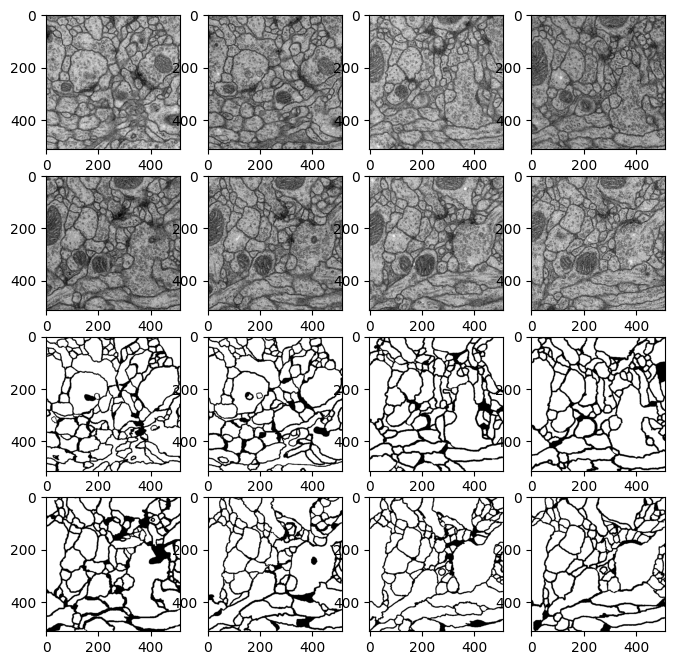

In [ ]:
import matplotlib.pyplot as plt

num_images_to_show = 16
dimensions = []
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))
for i in range(int(num_images_to_show/2)):
  random_number = random.randint(0, len(train_images))
  image_path = train_images[i]
  mask_path = train_labels[i]
  img_1 = plt.imread(image_path)
  img_1 = Image.open(image_path).convert("RGB")
  img_1_data = np.asarray(img_1)
  img_2 = plt.imread(mask_path)
  img_2 = Image.open(mask_path).convert("RGB")
  img_2_data = np.asarray(img_2)

  row = i // 4
  col = i % 4
  ax[row, col].imshow(img_1_data)
  ax[row+2, col].imshow(img_2_data)

plt.show()

## Data preprocessing class

In [ ]:
class image_preprocessing:


    Sky = [128,128,128]
    Building = [128,0,0]
    Pole = [192,192,128]
    Road = [128,64,128]
    Pavement = [60,40,222]
    Tree = [128,128,0]
    SignSymbol = [192,128,128]
    Fence = [64,64,128]
    Car = [64,0,128]
    Pedestrian = [64,64,0]
    Bicyclist = [0,128,192]
    Unlabelled = [0,0,0]

    COLOR_DICT = np.array([Sky, Building, Pole, Road, Pavement, Tree, SignSymbol, Fence, Car, Pedestrian, Bicyclist, Unlabelled])

    def __init__(self, train_path, test_path, augmented_path):
        self.train_path = train_path
        self.test_path = test_path
        self.augmented_path = augmented_path
        isExist = os.path.exists(self.augmented_path)
        if not isExist:
           # Create a new directory because it does not exist
           os.makedirs(self.augmented_path)

    def adjustData(self, img,mask, flag_multi_class, num_class):
        if(flag_multi_class):
            img = img / 255
            mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
            new_mask = np.zeros(mask.shape + (num_class,))
            for i in range(num_class):
                #for one pixel in the image, find the class in mask and convert it into one-hot vector
                new_mask[mask == i,i] = 1
            new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
            mask = new_mask
        elif(np.max(img) > 1):
            img = img / 255
            mask = mask /255
            mask[mask > 0.5] = 1
            mask[mask <= 0.5] = 0
        return (img,mask)

    def trainGenerator(self, batch_size, train_path, image_folder, mask_folder, aug_dict, image_color_mode = "grayscale",
                       mask_color_mode = "grayscale", image_save_prefix  = "image", mask_save_prefix  = "mask",
                       flag_multi_class = False, num_class = 2, save_to_dir_image = None, save_to_dir_label = None, target_size = (256,256), seed = 1):

        '''
        can generate image and mask at the same time
        use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
        if you want to visualize the results of generator, set save_to_dir = "your path"
        '''
        image_datagen = ImageDataGenerator(**aug_dict)
        mask_datagen = ImageDataGenerator(**aug_dict)
        image_generator = image_datagen.flow_from_directory(
            train_path,
            classes = [image_folder],
            class_mode = None,
            color_mode = image_color_mode,
            target_size = target_size,
            batch_size = batch_size,
            # save_to_dir = save_to_dir,
            save_to_dir = save_to_dir_image,
            save_prefix  = image_save_prefix,
            seed = seed)
        mask_generator = mask_datagen.flow_from_directory(
            train_path,
            classes = [mask_folder],
            class_mode = None,
            color_mode = mask_color_mode,
            target_size = target_size,
            batch_size = batch_size,
            # save_to_dir = save_to_dir,
            save_to_dir = save_to_dir_label,
            save_prefix  = mask_save_prefix,
            seed = seed)
        train_generator = zip(image_generator, mask_generator)
        for (img,mask) in train_generator:
            img,mask = self.adjustData(img,mask,flag_multi_class,num_class)
            yield (img,mask)

    def testGenerator(self, test_path, num_image = 30, target_size = (256,256),flag_multi_class = False,as_gray = True):
      for i in range(num_image):
          img = io.imread(os.path.join(test_path,"%d.png"%i),as_gray = as_gray)
          img = img / 255
          img = trans.resize(img,target_size)
          img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
          img = np.reshape(img,(1,)+img.shape)
          yield img


    def geneTrainNpy(image_path, mask_path, flag_multi_class = False, num_class = 2, image_prefix = "image",
                     mask_prefix = "mask", image_as_gray = True, mask_as_gray = True):
        image_name_arr = glob.glob(os.path.join(image_path,"%s*.png"%image_prefix))
        image_arr = []
        mask_arr = []
        for index,item in enumerate(image_name_arr):
            img = io.imread(item,as_gray = image_as_gray)
            img = np.reshape(img,img.shape + (1,)) if image_as_gray else img
            mask = io.imread(item.replace(image_path,mask_path).replace(image_prefix,mask_prefix),as_gray = mask_as_gray)
            mask = np.reshape(mask,mask.shape + (1,)) if mask_as_gray else mask
            img, mask = self.adjustData(img, mask, flag_multi_class, num_class)
            image_arr.append(img)
            mask_arr.append(mask)
        image_arr = np.array(image_arr)
        mask_arr = np.array(mask_arr)
        return image_arr, mask_arr

    def labelVisualize(num_class, color_dict,img):
        img = img[:,:,0] if len(img.shape) == 3 else img
        img_out = np.zeros(img.shape + (3,))
        for i in range(num_class):
            img_out[img == i,:] = color_dict[i]
        return img_out / 255


    def saveResult(self, save_path, npyfile, flag_multi_class = False, num_class = 2):
        for i,item in enumerate(npyfile):
            img = self.labelVisualize(num_class,self.COLOR_DICT,item) if flag_multi_class else item[:,:,0]
            io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

## Running-Section

### defining data generator

In [ ]:
# if you don't want to do data augmentation, set data_gen_args as an empty dict.
# data_gen_args = dict()

train_path = '/content/drive/My Drive/MLSys/Project_phase1&2/data/train'
test_path = '/content/drive/My Drive/MLSys/Project_phase1&2/data/test/image'
aug_path =  "/content/drive/My Drive/MLSys/Project_phase1&2/data/train/aug/"
aug_image_path =  "/content/drive/My Drive/MLSys/Project_phase1&2/data/train/aug/image/"
aug_label_path =  "/content/drive/My Drive/MLSys/Project_phase1&2/data/train/aug/label/"

ip = image_preprocessing(train_path, test_path, aug_path)

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     preprocessing_function=tfa.image.gaussian_filter2d,
                     fill_mode='nearest',
                    )

In [ ]:
myGenerator = ip.trainGenerator(20, train_path, 'image', 'label', data_gen_args, save_to_dir_image = aug_image_path, save_to_dir_label = aug_label_path)

### visualize data augmentation result

In [ ]:
# aftert this step we will see 60 transformed images and their masks in data/train/aug
num_batch = 3
for i,batch in enumerate(myGenerator):
    if(i >= num_batch):
        break

### Transfer learning

In [ ]:
import numpy as np
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)

def transfer_learning(model, parent_path):
  # get the path/directory
  folder_dir = parent_path
  features = np.empty((30, 7, 7, 512), float)
  for images in os.listdir(folder_dir):
    # check if the image ends with png
    if (images.endswith(".png")):
      img_path = parent_path + images
      img = image.load_img(img_path, target_size=(224, 224))
      x = image.img_to_array(img)
      x = np.expand_dims(x, axis=0)
      x = preprocess_input(x)
      np.append(features, model.predict(x), axis=0)

  return features

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model = VGG16(weights='imagenet', include_top=False)
parent_path = train_path + '/image/'
features = transfer_learning(model, parent_path)
print(features.shape)

1/1 [==============================] - 0s 19ms/step
(30, 7, 7, 512)


# MLSys_Project_Phase2

## Model Selection and Definition and training and testing

### UNet Using TensorFlow

In [ ]:
import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
  inputs = Input(input_size)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)

  model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

  #model.summary()

  if(pretrained_weights):
    model.load_weights(pretrained_weights)

  return model

#### Train Unet with membrane data


membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size, rows, cols, channel = 1)

In [ ]:
data_gen_args = dict(rotation_range=0.2,
                     width_shift_range=0.05,
                     height_shift_range=0.05,
                     shear_range=0.05,
                     zoom_range=0.05,
                     horizontal_flip=True,
                     preprocessing_function=tfa.image.gaussian_filter2d,
                     fill_mode='nearest',
                    )
myGene = ip.trainGenerator(2, train_path,'image','label',data_gen_args, save_to_dir_image = None, save_to_dir_label = None)
model = unet()
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/MLSys/Project_phase1&2/unet_membrane.hdf5', monitor='loss',verbose=1, save_best_only=True)
model.fit_generator(myGene,steps_per_epoch=2000,epochs=5,callbacks=[model_checkpoint])

Found 30 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
<ipython-input-14-d540dc9ab1ee>:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(myGene,steps_per_epoch=2000,epochs=5,callbacks=[model_checkpoint])


2000/2000 [==============================] - ETA: 0s - loss: 0.2556 - accuracy: 0.8808
Epoch 1: loss improved from inf to 0.25555, saving model to /content/drive/My Drive/MLSys/Project_phase1&2/unet_membrane.hdf5
2000/2000 [==============================] - 387s 193ms/step - loss: 0.2556 - accuracy: 0.8808
Epoch 2/5
2000/2000 [==============================] - ETA: 0s - loss: 0.1250 - accuracy: 0.9451
Epoch 2: loss improved from 0.25555 to 0.12498, saving model to /content/drive/My Drive/MLSys/Project_phase1&2/unet_membrane.hdf5
2000/2000 [==============================] - 385s 193ms/step - loss: 0.1250 - accuracy: 0.9451
Epoch 3/5
2000/2000 [==============================] - ETA: 0s - loss: 0.0970 - accuracy: 0.9576
Epoch 3: loss improved from 0.12498 to 0.09699, saving model to /content/drive/My Drive/MLSys/Project_phase1&2/unet_membrane.hdf5
2000/2000 [==============================] - 385s 192ms/step - loss: 0.0970 - accuracy: 0.9576
Epoch 4/5
2000/2000 [===========================

#### Hyper-Parameter Optimization

In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 13.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

def build_model(hp):
  inputs = Input((256,256,1))

  # Tune the number of filters in the first convolutional layer
  conv1 = Conv2D(hp.Int('conv1_filters', min_value=32, max_value=256, step=32), 3, activation='relu', padding='same')(inputs)
  conv1 = Conv2D(hp.Int('conv1_filters', min_value=32, max_value=256, step=32), 3, activation='relu', padding='same')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

  # Tune the number of filters in the second convolutional layer
  conv2 = Conv2D(hp.Int('conv2_filters', min_value=64, max_value=512, step=64), 3, activation='relu', padding='same')(pool1)
  conv2 = Conv2D(hp.Int('conv2_filters', min_value=64, max_value=512, step=64), 3, activation='relu', padding='same')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)

   # Tune the dropout rate
  drop4 = Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1))(conv4)

  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
  drop5 = Dropout(0.5)(conv5)

  up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

  up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

  up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

  up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)

  # Tune the learning rate
  lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  model.compile(optimizer = Adam(lr = lr), loss = 'binary_crossentropy', metrics = ['accuracy'])

  return model

<ipython-input-11-aa74228551e6>:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
# Define the search space for hyperparameters
tuner_search_space = {
    'conv1_filters': [32, 64, 128, 256],
    'conv2_filters': [64, 128, 256, 512],
    'dropout_rate': [0.1, 0.2, 0.3, 0.4, 0.5],
    'learning_rate': [1e-2, 1e-3, 1e-4]
}

tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=10,
                     directory='unet_hyperparameter_optimization',
                     project_name='unet')

# Train the tuned model
myGene = ip.trainGenerator(2, aug_path,'image','label',data_gen_args, save_to_dir_image = None, save_to_dir_label = None)
valGen = ip.trainGenerator(2, train_path,'image','label',data_gen_args, save_to_dir_image = None, save_to_dir_label = None)

tuner.search(myGene, steps_per_epoch=2000, epochs=5, validation_data=valGen, validation_steps=500)

# Get the best set of hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Train the final model with the best hyperparameters on the full dataset

final_model = build_model(best_hp)
model_checkpoint = ModelCheckpoint('/content/drive/My Drive/MLSys/Project_phase1&2/unet_membrane_afterHPO.hdf5', monitor='loss',verbose=1, save_best_only=True)
final_model.fit_generator(myGene, steps_per_epoch=2000, epochs=10)


Trial 1 Complete [01h 04m 41s]
val_accuracy: 0.9614470601081848

Best val_accuracy So Far: 0.9614470601081848
Total elapsed time: 01h 04m 41s

Search: Running Trial #2

Value             |Best Value So Far |Hyperparameter
128               |256               |conv1_filters
256               |128               |conv2_filters
0.2               |0.3               |dropout_rate
0.001             |0.0001            |learning_rate

Epoch 1/5
   6/2000 [..............................] - ETA: 8:04 - loss: 0.6952 - accuracy: 0.6911

2000/2000 [==============================] - 594s 295ms/step - loss: 0.5694 - accuracy: 0.7785 - val_loss: 0.5304 - val_accuracy: 0.7780
Epoch 2/5
 672/2000 [=========>....................] - ETA: 5:34 - loss: 0.5289 - accuracy: 0.7787

#### Test TF model and save predicted results

In [ ]:
testGene = ip.testGenerator(test_path)
test_pred_path = '/content/drive/My Drive/MLSys/Project_phase1&2/data/test/pred'
model = unet()
model.load_weights('/content/drive/My Drive/MLSys/Project_phase1&2/unet_membrane.hdf5')
results = model.predict(testGene, 30, verbose=1)
ip.saveResult(test_pred_path, results)

## Model Evaluation

### With ground truth

In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random
from PIL import Image

# Load the dataset
data_dir = '/content/drive/My Drive/MLSys/Project_phase1&2/data/train/aug/'

def load_data(data_folder):
    all_images = []
    all_labels = []
    aug_folder_path = "/content/drive/My Drive/MLSys/Project_phase1&2/data/train/aug/label"
    for foldername in os.listdir(data_folder):
        if foldername == 'image':
          folder_path = os.path.join(data_folder, foldername)
          for filename in os.listdir(folder_path):
            label_filename = filename.replace("image", "mask")
            image_path = os.path.join(folder_path, filename)
            label_path = os.path.join(aug_folder_path, label_filename)
            all_images.append(image_path)
            all_labels.append(label_path)

    return np.array(all_images), np.array(all_labels)

# Combine the images
all_images, all_labels = load_data(data_dir)

# Count the number of data in each class
print("Number of all Images: ", len(all_images))

Number of all Images:  120


In [ ]:
from sklearn.model_selection import train_test_split

# Shuffle the data
indices = np.arange(len(all_images))
np.random.shuffle(indices)
X = all_images[indices]
y = all_labels[indices]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Split train set into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Print the shapes of the resulting datasets
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Training set: (76,) (76,)
Validation set: (20,) (20,)
Test set: (24,) (24,)


In [ ]:
import numpy as np

def compute_accuracy(preds, labels):
    preds = (preds > 0.5).float()
    correct = (preds == labels).float().sum()
    accuracy = correct / labels.numel()
    return accuracy

def compute_iou(preds, labels):
    preds = (preds > 0.5).float()
    intersection = (preds * labels).float().sum()
    union = (preds + labels).float().sum() - intersection
    iou = intersection / union
    return iou

In [ ]:
def testGenerator(test_paths, target_size = (256,256), flag_multi_class = False, as_gray = True):
      for i in range(len(test_paths)):
          img = io.imread(test_paths[i],as_gray = as_gray)
          img = img / 255
          img = trans.resize(img,target_size)
          img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
          img = np.reshape(img,(1,)+img.shape)
          yield img

def test_gt(test_paths, target_size = (256,256), flag_multi_class = False, as_gray = True):
      labels = []
      for i in range(len(test_paths)):
          img = io.imread(test_paths[i],as_gray = as_gray)
          img = img / 255
          img = trans.resize(img,target_size)
          img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
          img = np.reshape(img,(1,)+img.shape)
          labels.append(img)
      return labels

In [ ]:
test_image_Gene = testGenerator(X_test)

model = unet()
model.load_weights('/content/drive/My Drive/MLSys/Project_phase1&2/unet_membrane.hdf5')
results = model.predict(test_image_Gene, 30, verbose=1)
test_y_gt = np.array(test_gt(y_test)).squeeze(axis = 1)
test_X_gt = np.array(test_gt(X_test)).squeeze(axis = 1)

24/24 [==============================] - 1s 34ms/step


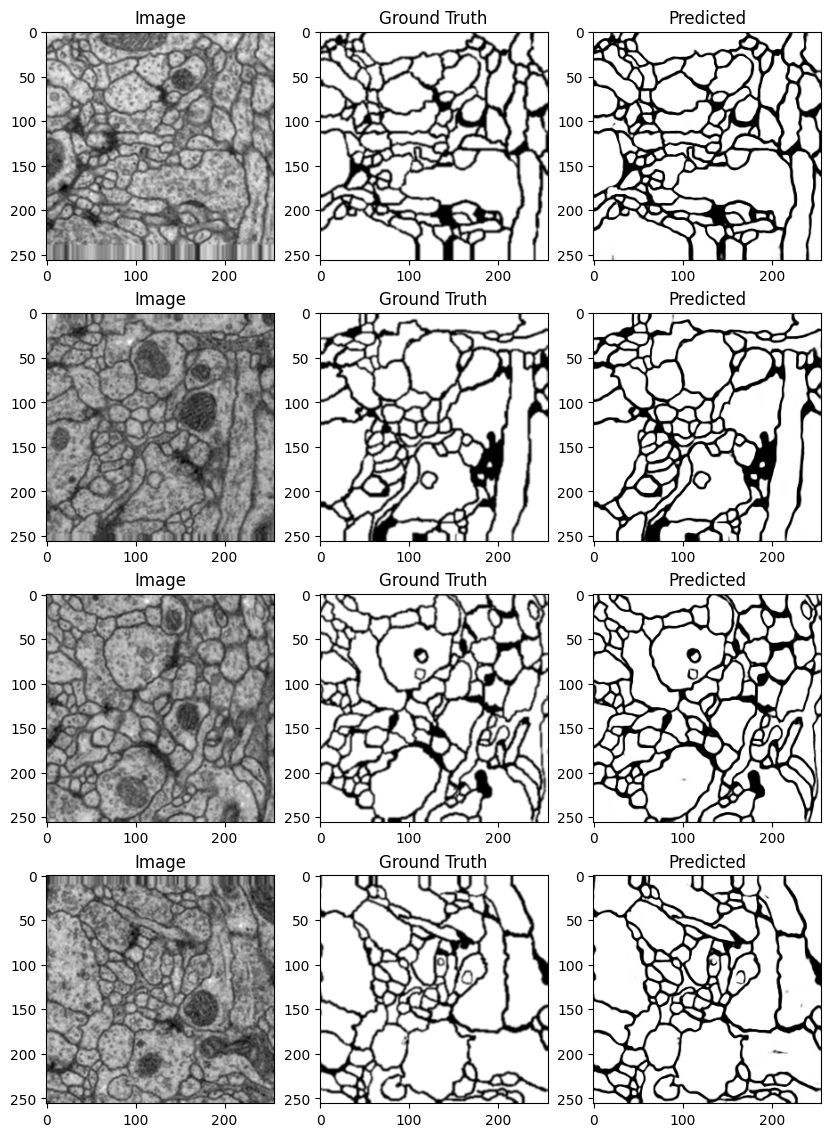

ACCURACY: 0.465899795293808
IoU: 0.9412606358528137


In [ ]:
import matplotlib.pyplot as plt
import torchvision
import torch

num_images_to_show = 12
dimensions = []
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10, 14))
for i in range(int(num_images_to_show/3)):
  random_number = random.randint(0, len(test_X_gt))
  y_gt_tensor = torch.from_numpy(test_y_gt)[i]
  x_gt_tensor = torch.from_numpy(test_X_gt)[i]
  pred_tensor = torch.from_numpy(results)[i]

  image_pil_1 = torchvision.transforms.ToPILImage()(x_gt_tensor.T).convert("RGB")
  image_pil_2 = torchvision.transforms.ToPILImage()(y_gt_tensor.T).convert("RGB")
  image_pil_3 = torchvision.transforms.ToPILImage()(pred_tensor.T).convert("RGB")

  row = i % 4

  ax[row, 0].imshow(image_pil_1)
  ax[row, 1].imshow(image_pil_2)
  ax[row, 2].imshow(image_pil_3)
  ax[row,0].set_title('Image')
  ax[row,1].set_title('Ground Truth')
  ax[row,2].set_title('Predicted')

plt.show()

print("ACCURACY: " + str(compute_accuracy(torch.from_numpy(test_y_gt), torch.from_numpy(results)).item()))
print("IoU: " + str(compute_iou(torch.from_numpy(test_y_gt), torch.from_numpy(results)).item()))

### without ground truth

#### Showing tests and model prediction for them

In [ ]:
import os
import numpy as np

# Load the dataset
data_dir = '/content/drive/My Drive/MLSys/Project_phase1&2/data/test/'

def load_data(data_folder):
    all_images = []
    all_preds = []
    pred_folder_path = "/content/drive/My Drive/MLSys/Project_phase1&2/data/test/pred"
    for foldername in os.listdir(data_folder):
        if foldername == 'image':
          folder_path = os.path.join(data_folder, foldername)
          for filename in os.listdir(folder_path):
            label_filename = filename.replace(".png", "_predict.png")
            image_path = os.path.join(folder_path, filename)
            preds_path = os.path.join(pred_folder_path, label_filename)
            all_images.append(image_path)
            all_preds.append(preds_path)

    return np.array(all_images), np.array(all_preds)

# Combine the images
test_images, test_preds = load_data(data_dir)

# Count the number of data in each class
print("Number of Test Images: ", len(test_images))

Number of Test Images:  30


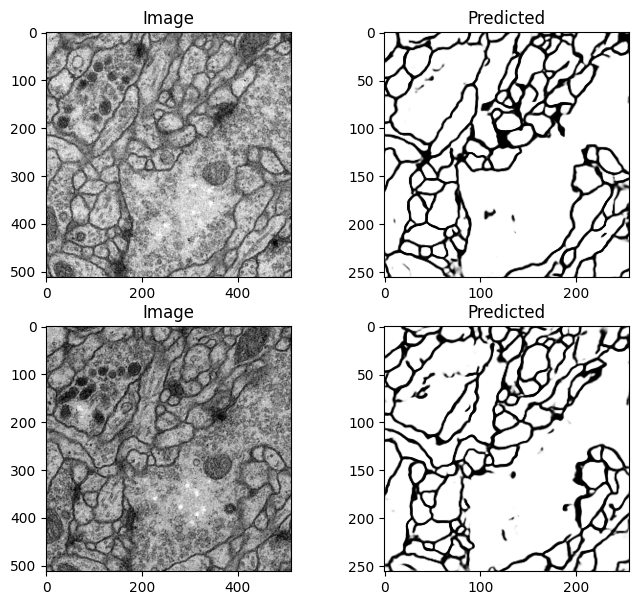

In [ ]:
import matplotlib.pyplot as plt


num_images_to_show = 4

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 7))
for i in range(int(num_images_to_show/2)):
  random_number = random.randint(0, len(test_images))
  image_path = test_images[i]
  mask_path = test_preds[i]
  img_1 = plt.imread(image_path)
  img_1 = Image.open(image_path).convert("RGB")
  img_1_data = np.asarray(img_1)
  img_2 = plt.imread(mask_path)
  img_2 = Image.open(mask_path).convert("RGB")
  img_2_data = np.asarray(img_2)

  row = i % 2

  ax[row, 0].imshow(img_1_data)
  ax[row, 1].imshow(img_2_data)
  ax[row,0].set_title('Image')
  ax[row,1].set_title('Predicted')

plt.show()